In [2]:
from whobpyt.datatypes import par
from whobpyt.models.RWWABT import RNNRWWABT, ParamsRWWABT
from whobpyt.optimization.custom_cost_RWW import CostsRWW
from whobpyt.run import Model_fitting
from sklearn.model_selection import train_test_split

# array and pd stuff
import numpy as np
import pandas as pd
from scipy.io import loadmat # for reading in the .mat files
import torch


# viz stuff
import matplotlib.pyplot as plt

In [3]:
def get_avg_fc(fcs):
    corr_matrices = []

    for data in fcs:
        fc = np.corrcoef(data.T)
        corr_matrices.append(fc)

    stacked_corr = np.stack(corr_matrices, axis = 0)
    avg_corr = np.mean(stacked_corr, axis =0)
    
    return avg_corr

In [4]:
def get_avg_fmr(fmris):
    stacked_corr = np.stack(fmris, axis = 0)
    avg_corr = np.mean(stacked_corr, axis =0)
    
    return avg_corr

In [1]:
# %%
# load raw data and get SC empirical BOLD and FC

sc = np.genfromtxt('../data/DTI_fiber_consensus_HCP.csv', delimiter=',')

patients = pd.read_csv('../data/ADNIMERGE/ADNIMERGE_29Apr2024_wFiles.csv')
patients = patients[patients['DX_bl'] == 'CN']

fcs = []

for file in patients['FC_DATA']:
    fc = loadmat(f'../{file}')
    fc = fc['ROI_activity'][:100, :]
    if fc.shape[1] == 197:
        fc = fc.T
        fcs.append(fc)

print(len(fcs))

# normalise all fcs - zscore
for i, fc in enumerate(fcs):
    fcs[i] = (fc - fc.mean(axis=0)) / fc.std(axis=0)

train_data, test_data = train_test_split(fcs, test_size=0.2, random_state=42)

print('Training set: ', len(train_data))
print('Test set: ', len(test_data))

NameError: name 'np' is not defined

In [8]:
# %%
# %%
# define options for wong-wang model
node_size = 100
mask = np.tril_indices(node_size, -1)
num_epochs = 100
TPperWindow = 20
# step_size = 0.05
step_size = 0.1
input_size = 2
tr = 0.75
repeat_size = 5
ts_length = fcs[0].shape[0]


In [9]:
SC = (sc + sc.T) * 0.5
sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))

fc_emp_train = get_avg_fc(train_data)
fc_emp_test = get_avg_fc(test_data)

In [10]:
# %%
params = ParamsRWWABT(bAB_E=par(val=0.1, fit_par=True), sAB_E=par(val=1.7, fit_par=True), bt_E=par(val=-0.5, fit_par=True),
                      st_E=par(val=-2.8, fit_par=True), bAB_I=par(val=0.3, fit_par=True), sAB_I=par(val=-3.1, fit_par=True))

# params = ParamsRWWABT(bAB_E=par(val=0), sAB_E=par(val=0), bt_E=par(val=0),
#                       st_E=par(val=0), bAB_I=par(val=0), sAB_I=par(val=0))

# call model want to fit

abeta_file = np.genfromtxt(f'../data/avg_scans/AB_CN.csv', delimiter=",")
abeta = torch.tensor(abeta_file, dtype=torch.float32)

tau_file = np.genfromtxt(f'../data/avg_scans/TAU_CN.csv', delimiter=",")
tau = torch.tensor(tau_file, dtype=torch.float32)

model = RNNRWWABT(node_size, TPperWindow, step_size, repeat_size, tr, sc, abeta, tau, use_fit_gains=True, params=params)

# %%
# create objective function
ObjFun = CostsRWW(model)

# %%
# call model fit
F = Model_fitting(model, ObjFun)

In [11]:
# Model Training
# ---------------------------------------------------
#
F.train(u = 0, empFcs = [torch.from_numpy(fc_emp_train)], num_epochs = num_epochs, num_windows = int(ts_length / TPperWindow), learningrate = 0.1, early_stopping=True)

Epoch:  0
epoch:  0 loss: 11.38274375061384 Pseudo FC_cor:  0.13501866619159728
Epoch:  1
epoch:  1 loss: 9.608066278798573 Pseudo FC_cor:  0.132334892224285
Epoch:  2
epoch:  2 loss: 9.05144346588749 Pseudo FC_cor:  0.22043038767342352
Epoch:  3
epoch:  3 loss: 9.318759877104004 Pseudo FC_cor:  0.18203969567526848
Epoch:  4
epoch:  4 loss: 8.845866555680201 Pseudo FC_cor:  0.23986957088979016
Epoch:  5
epoch:  5 loss: 9.403986564049058 Pseudo FC_cor:  0.19238319998568326
Epoch:  6
epoch:  6 loss: 9.443682009521162 Pseudo FC_cor:  0.13281758353642956
Epoch:  7
epoch:  7 loss: 9.237980195299418 Pseudo FC_cor:  0.2233029859482155
Epoch:  8
epoch:  8 loss: 9.284816880171917 Pseudo FC_cor:  0.20684961606164232
Epoch:  9
epoch:  9 loss: 9.559699876171738 Pseudo FC_cor:  0.2183817059563947
Epoch:  10
epoch:  10 loss: 9.6419663564443 Pseudo FC_cor:  0.19441193885739336
Epoch:  11
epoch:  11 loss: 9.590732705836547 Pseudo FC_cor:  0.15604071966085173
Epoch:  12
epoch:  12 loss: 8.8083439910248

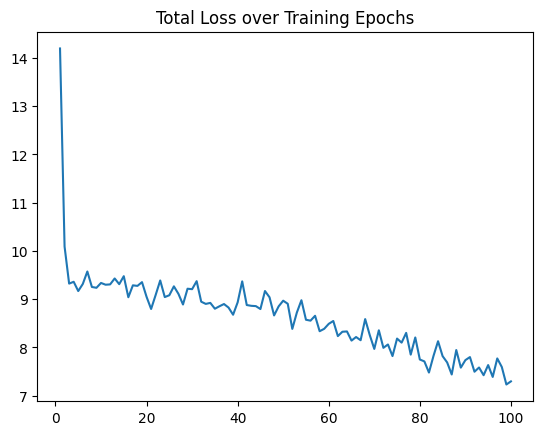

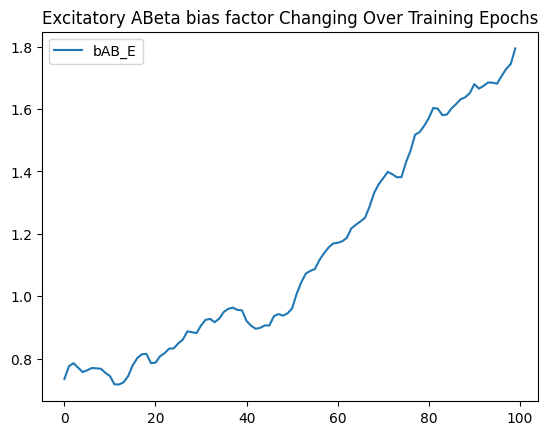

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Plots of loss over Training
ax[0].plot(np.arange(1,len(F.trainingStats.loss)+1), F.trainingStats.loss, label='loss')
ax[0].set_title("Total Loss over Training Epochs")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
# plt.show()

# %%
# Plots of parameters values over Training
ax[1].plot(F.trainingStats.fit_params['bAB_E'], label = "bAB_E")
ax[1].plot(F.trainingStats.fit_params['sAB_E'], label = "sAB_E")
ax[1].plot(F.trainingStats.fit_params['bAB_I'], label = "bAB_I")
ax[1].plot(F.trainingStats.fit_params['sAB_I'], label = "sAB_I")
ax[1].plot(F.trainingStats.fit_params['bt_E'], label = "bt_E")
ax[1].plot(F.trainingStats.fit_params['st_E'], label = "st_E")
ax[1].legend()
# ax[1].set_title("Excitatory ABeta bias factor Changing Over Training Epochs")
ax[1].set_title("Bias and Scaling factors Changing Over Training Epochs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Value")
plt.show()

Pearson Correlations:  0.579555214199444


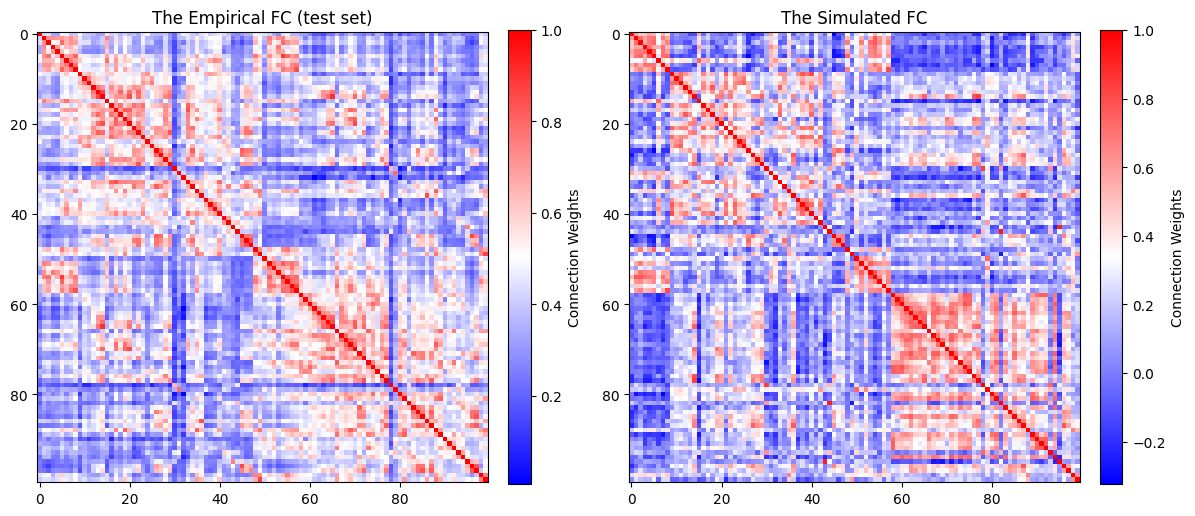

In [13]:
# Model Evaluation (with 20 window for warmup)
# ---------------------------------------------------

# Simulate the functional connectivity:
ts_sim, fc_sim = F.simulate(u =0, num_windows=int(ts_length/TPperWindow), base_window_num=20)

# average the evaluation scores across empirical data
fc_cor = F.evaluate(empFcs=[fc_emp_test], fc_sims=[fc_sim])

# -----------------------------------------------------------
# Plot the simulated FC + BOLD time series:

# Plot the FC and the test FC
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
im0 = ax[0].imshow(fc_emp_test, cmap='bwr')
ax[0].set_title('The Empirical FC (test set)')
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04, label='Connection Weights')

im1 = ax[1].imshow(fc_sim, cmap='bwr')
ax[1].set_title('The Simulated FC')
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04, label='Connection Weights')
plt.show()

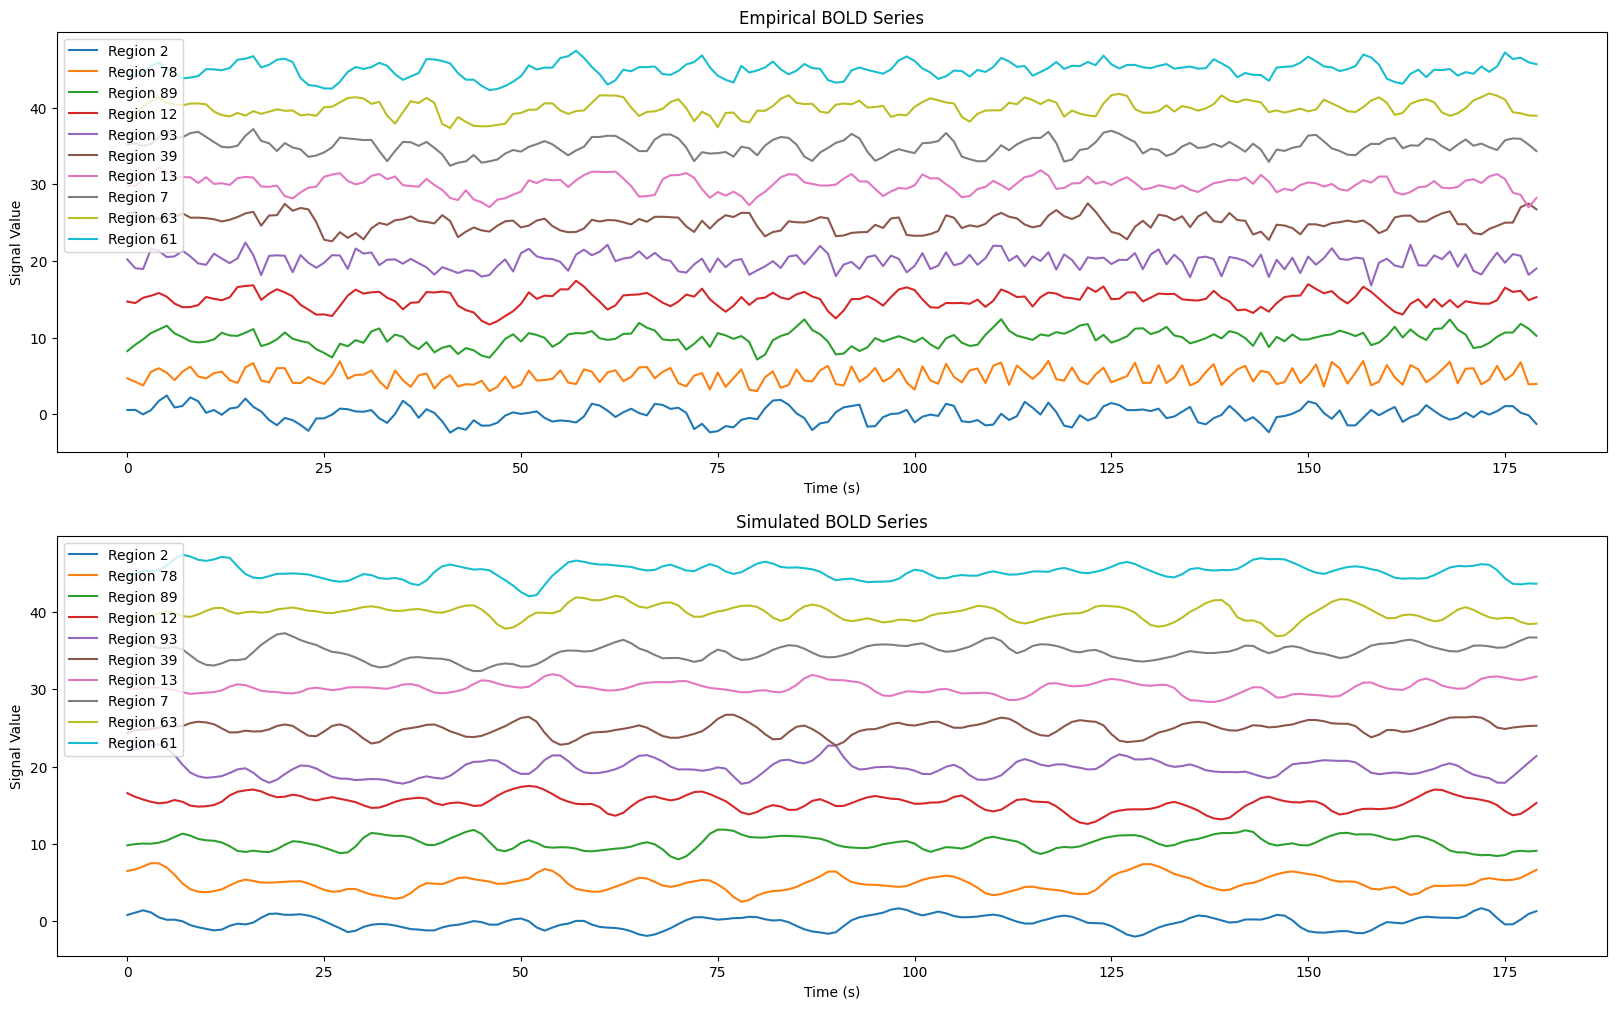

In [25]:
# Plot E I and simulated BOLD - separate lines for regions
emp_bold = test_data[1][:180].T
sim_bold = ts_sim
# Standardise times series
sim_bold = (sim_bold - sim_bold.mean(axis=0)) / sim_bold.std(axis=0)

# Select 10 unique random column indices
region_indices = np.random.choice(emp_bold.shape[0], 10, replace=False)
# # Select the columns using the random indices
subset_emp = emp_bold[region_indices, :]
subset_sim = sim_bold[region_indices, :]

k = 0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

for idx, sub_array in enumerate(subset_emp):
    ax1.plot(sub_array + k, label=f'Region {region_indices[idx]}')
    k += 5

ax1.legend(loc='upper left')

# Add labels and title
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Signal Value')
ax1.set_title('Empirical BOLD Series')
# plt.show()

k = 0

for idx, sub_array in enumerate(subset_sim):
    ax2.plot(sub_array + k, label=f'Region {region_indices[idx]}')
    k += 5

# Add a legend to differentiate the plots
ax2.legend(loc='upper left')

# Add labels and title
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Signal Value')
ax2.set_title('Simulated BOLD Series')

plt.show()

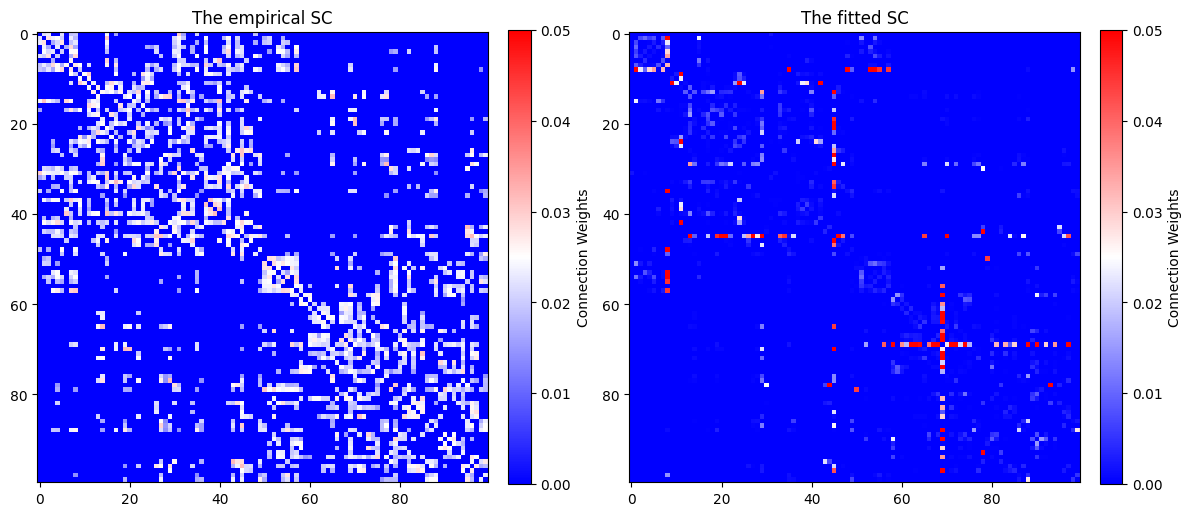

In [12]:
# Plot SC and fitted SC

fig, ax = plt.subplots(1, 2, figsize=(14, 8))
im0 = ax[0].imshow(sc, cmap='bwr', vmin = 0.0, vmax = 0.05)
ax[0].set_title('The empirical SC')
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04, label='Connection Weights')
im1 = ax[1].imshow(F.model.sc_fitted.detach().numpy(), cmap='bwr', vmin = 0.0, vmax = 0.05)
ax[1].set_title('The fitted SC')
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04, label='Connection Weights')
plt.show()

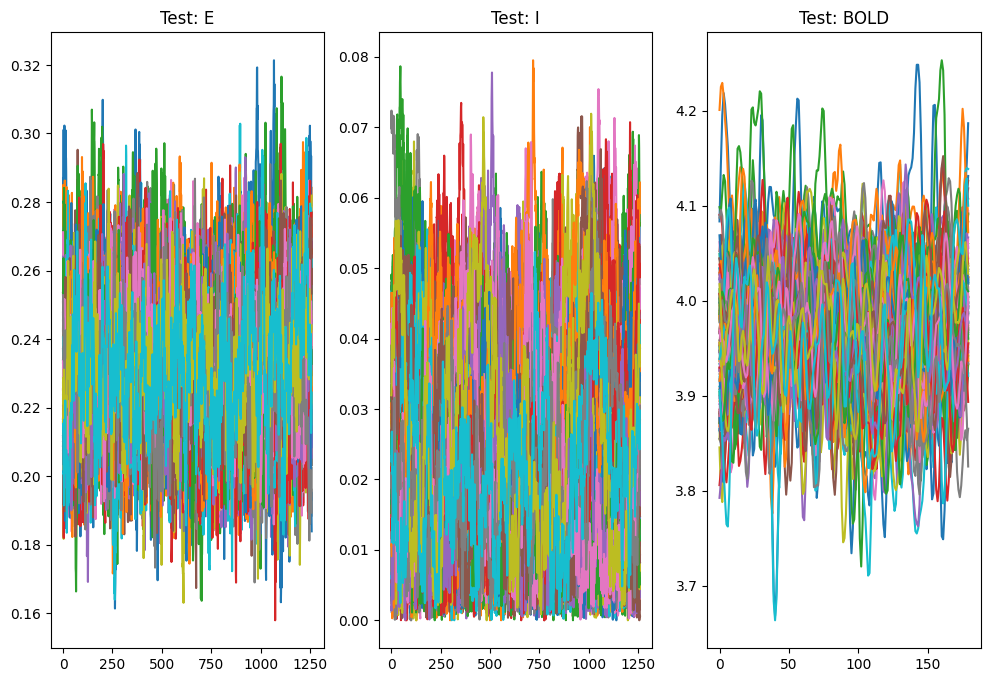

In [13]:
# Plot E I and simulated BOLD
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].plot(F.lastRec['E'].npTS().T)
ax[0].set_title('Test: E')
ax[1].plot(F.lastRec['I'].npTS().T)
ax[1].set_title('Test: I')
ax[2].plot(F.lastRec['bold'].npTS().T)
ax[2].set_title('Test: BOLD')
plt.show()

## Getting Prediction Statistics
Calculate average corr score and standard deviation

In [ ]:
iterations = 20
corrs = np.zeros(20)

for i in range(iterations):
    _, fc_sim = F.simulate(u =0, num_windows=int(ts_length/TPperWindow), base_window_num=20)

    # average the evaluation scores across empirical data
    fc_cor = F.evaluate(empFcs=[fc_emp_test], fc_sims=[fc_sim])
    corrs[i] = fc_cor

print('=================================================')
print('Mean FC Corr Score: ', np.mean(corrs))
print('Standard Dev for FC Corr Score: ', np.std(corrs))

## Saving + Loading Models

In [15]:
# F.save('100epoch_lr005_step01_g1000.pkl')

In [16]:
# import pickle

# # Load the model from the file
# with open('50epoch_lr01_step01_g100.pkl', 'rb') as f:
#     model = pickle.load(f)

In [17]:
# model.evaluate(u = 0, empRecs = [data_mean], TPperWindow = TPperWindow, base_window_num = 20)